In [1]:
! pip3 install -r requirements.txt

In [34]:
from os import walk
import socket
from scipy.io import arff
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn import metrics as mt
from sklearn.metrics import (accuracy_score,brier_score_loss, precision_score, recall_score,f1_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import time

In [3]:
if socket.gethostname() == 'Rohits-MacBook-Pro.local':
    rootdir = '/Users/rohitchanne/Documents/QTW_Case_Study_4/data/'
else: 
    rootdir = '' ##Enter file path name here 

In [4]:
filenames = next(walk(rootdir), (None, None, []))[2]  # [] if no file

In [8]:
df_bankruptcy_data = pd.DataFrame()

In [9]:
for f in filenames:
    data = arff.loadarff(f'{rootdir}/{f}')
    df_temp = pd.DataFrame(data[0])
    df_temp['year'] = f[0]
    df_temp['is_bankrupt'] = df_temp['class'].str.decode('utf-8').astype('int')
    df_temp.pop('class')
    df_temp.fillna(0, inplace=True)
    print(f'filename:{f}, {df_temp.shape}, {df_temp.columns[df_temp.isna().any()].tolist()}')
    df_bankruptcy_data = df_bankruptcy_data.append(df_temp, ignore_index=True)

filename:2year.arff, (10173, 66), []
filename:3year.arff, (10503, 66), []
filename:5year.arff, (5910, 66), []
filename:4year.arff, (9792, 66), []
filename:1year.arff, (7027, 66), []


In [103]:
df_temp = pd.DataFrame(c_data[0][0])

In [15]:
df_bankruptcy_data.shape

(43405, 66)

In [12]:
df_bankruptcy_data.columns[df_bankruptcy_data.isna().any()].tolist()

[]

In [14]:
df_bankruptcy_data[df_bankruptcy_data['Attr1'].isnull()]

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,year,is_bankrupt


### Treebased models

In [16]:
num_estimators = 50

tree_based_models = {
    'Stump':             DecisionTreeClassifier(max_depth=1, min_samples_leaf=1),
    'Tree':              DecisionTreeClassifier(),
    'Random Trees':      RandomForestClassifier(max_depth=50, n_estimators=num_estimators),
    'Extra Random Trees': ExtraTreesClassifier(n_estimators=num_estimators,min_samples_split=2),
    'Boosted Tree':       GradientBoostingClassifier(n_estimators=num_estimators), #takes a long time
}

In [17]:
def cv_train(name,model,x,y, num_cv_iterations = 3):
    print(f"====Performing Cross Validation for {name}")
    print(f" Iteration ", end = '')
    iter_num=0
    res=pd.DataFrame()
    
    cv_object = ms.StratifiedShuffleSplit(n_splits=num_cv_iterations,
                         random_state=0,
                         test_size  = 0.30)

    for train_indices, test_indices in cv_object.split(x,y):
        t = time.time()
        print(f" {iter_num},", end = '')

        X_train = x.iloc[train_indices]
        y_train = y.iloc[train_indices]

        X_test = x.iloc[test_indices]
        y_test = y.iloc[test_indices]

        model.fit(X_train,y_train)  # train object
        y_hat = model.predict(X_test) # get test set precitions

        conf = mt.confusion_matrix(y_test,y_hat)
        
        row=pd.DataFrame([iter_num],columns=['Iteration'])
        row["accuracy"]=accuracy_score(y_test, y_hat)
        row["precision"]=precision_score(y_test, y_hat, average="macro")
        row["recall"]=recall_score(y_test, y_hat, average="macro")
        row["f1"]=f1_score(y_test, y_hat, average="macro")
        row["average_seconds"]= np.round(time.time() - t)

        res=res.append(row)
        iter_num+=1
    
    #Summarize CV Results 
    summary=res.drop("Iteration",axis=1).agg("mean").to_frame().T
    #summary.insert(0,"model",model)
    summary.insert(0,"name",name)
    print("  Cross-validation complete")

    return(summary)

In [18]:
cv_results=pd.DataFrame()

In [20]:
X = df_bankruptcy_data.loc[:,df_bankruptcy_data.columns != 'is_bankrupt']
y = df_bankruptcy_data['is_bankrupt']

In [21]:
for name,model in tree_based_models.items():
    cv_results=cv_results.append(cv_train(name,model,X,y))

====Performing Cross Validation for Stump
 Iteration  0,

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 1,

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 2,

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  Cross-validation complete
====Performing Cross Validation for Tree
 Iteration  0, 1, 2,  Cross-validation complete
====Performing Cross Validation for Random Trees
 Iteration  0, 1, 2,  Cross-validation complete
====Performing Cross Validation for Extra Random Trees
 Iteration  0, 1, 2,  Cross-validation complete
====Performing Cross Validation for Boosted Tree
 Iteration  0, 1, 2,  Cross-validation complete


In [22]:
cv_results

,name,accuracy,precision,recall,f1,average_seconds
0,Stump,0.951851,0.475925,0.500000,0.487666,0.0
0,Tree,0.954231,0.750392,0.769772,0.759585,3.0
0,Random Trees,0.963114,0.908747,0.640177,0.702557,12.0
0,Extra Random Trees,0.948907,0.606174,0.514101,0.516085,3.0
0,Boosted Tree,0.964598,0.961150,0.638181,0.705686,29.0


### Gridsearch for Random Forest

In [29]:
rf_parameters={
 'bootstrap': [True, False],
 'max_depth': [10, 25 ,50],
 'max_features': ['sqrt', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 100],
 'criterion': ['gini','entropy']
}

rf_classifier=RandomForestClassifier(random_state=123)
rf_classifier_cv=GridSearchCV(rf_classifier,rf_parameters,cv=3, scoring="f1", n_jobs=1,verbose=10)
rf_classifier_cv.fit(X,y)
print(type)
print(rf_classifier_cv.best_params_)
print("-----")

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
[CV] bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.219, total=   7.4s
[CV] bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s


[CV]  bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.210, total=   7.3s
[CV] bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.8s remaining:    0.0s


[CV]  bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.216, total=   7.5s
[CV] bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.2s remaining:    0.0s


[CV]  bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.240, total=  14.6s
[CV] bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   36.9s remaining:    0.0s


[CV]  bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.194, total=  14.3s
[CV] bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   51.2s remaining:    0.0s


[CV]  bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.155, total=  14.7s
[CV] bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.1min remaining:    0.0s


[CV]  bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50, score=0.258, total=   7.4s
[CV] bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.2min remaining:    0.0s


[CV]  bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50, score=0.217, total=   7.3s
[CV] bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.3min remaining:    0.0s


[CV]  bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50, score=0.222, total=   7.4s
[CV] bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.5min remaining:    0.0s


[CV]  bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100, score=0.216, total=  14.6s
[CV] bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100, score=0.208, total=  14.4s
[CV] bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100, score=0.166, total=  14.5s
[CV] bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50, score=0.242,

[CV]  bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50, score=0.264, total=   7.3s
[CV] bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100, score=0.160, total=  14.4s
[CV] bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100, score=0.175, total=  14.1s
[CV] bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100, score=0.194, 

[CV]  bootstrap=True, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50, score=0.108, total=   5.5s
[CV] bootstrap=True, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50, score=0.058, total=   5.6s
[CV] bootstrap=True, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100, score=0.058, total=  11.2s
[CV] bootstrap=True, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100, score=0.

[CV]  bootstrap=True, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50, score=0.103, total=   5.5s
[CV] bootstrap=True, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50, score=0.103, total=14.6min
[CV] bootstrap=True, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50, score=0.085, total=   6.9s
[CV] bootstrap=True, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100, score=0.042, tota

[CV]  bootstrap=True, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, score=0.448, total=  24.2s
[CV] bootstrap=True, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, score=0.368, total=  12.0s
[CV] bootstrap=True, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, score=0.356, total=  11.4s
[CV] bootstrap=True, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, score=0.466, tota

[CV]  bootstrap=True, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100, score=0.300, total=  21.6s
[CV] bootstrap=True, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100, score=0.407, total=  22.5s
[CV] bootstrap=True, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50, score=0.352, total=  11.0s
[CV] bootstrap=True, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50, score=0.283,

[CV]  bootstrap=True, criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, score=0.317, total=  17.6s
[CV] bootstrap=True, criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, score=0.253, total=  17.2s
[CV] bootstrap=True, criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, score=0.362, total=  17.6s
[CV] bootstrap=True, criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.309, t

[CV]  bootstrap=True, criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50, score=0.325, total=   8.6s
[CV] bootstrap=True, criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, score=0.279, total=  16.3s
[CV] bootstrap=True, criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, score=0.182, total=  16.3s
[CV] bootstrap=True, criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, score=

[CV]  bootstrap=True, criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.323, total=  10.6s
[CV] bootstrap=True, criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.437, total=  11.0s
[CV] bootstrap=True, criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100, score=0.381, total=  21.8s
[CV] bootstrap=True, criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100, score=0.326, to

[CV]  bootstrap=True, criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.342, total=   7.9s
[CV] bootstrap=True, criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.281, total=   7.6s
[CV] bootstrap=True, criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.340, total=   7.9s
[CV] bootstrap=True, criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.332, tota

[CV]  bootstrap=True, criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100, score=0.349, total=  15.6s
[CV] bootstrap=True, criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50, score=0.312, total=   8.0s
[CV] bootstrap=True, criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50, score=0.235, total=   7.5s
[CV] bootstrap=True, criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50, score=0.342,

[CV]  bootstrap=True, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.230, total=  14.9s
[CV] bootstrap=True, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.314, total=  16.0s
[CV] bootstrap=True, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50, score=0.332, total=   8.0s
[CV] bootstrap=True, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators

[CV]  bootstrap=True, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, score=0.262, total=  24.5s
[CV] bootstrap=True, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, score=0.194, total=  15.3s
[CV] bootstrap=True, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, score=0.308, total=  15.8s
[CV] bootstrap=True, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_est

[CV]  bootstrap=True, criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50, score=0.093, total=   6.0s
[CV] bootstrap=True, criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100, score=0.128, total=  12.0s
[CV] bootstrap=True, criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100, score=0.101, total=  11.8s
[CV] bootstrap=True, criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimato

[CV]  bootstrap=True, criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50, score=0.103, total=   6.3s
[CV] bootstrap=True, criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50, score=0.131, total=   6.7s
[CV] bootstrap=True, criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100, score=0.096, total=  13.0s
[CV] bootstrap=True, criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators

[CV]  bootstrap=True, criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50, score=0.364, total=   9.5s
[CV] bootstrap=True, criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50, score=0.342, total=   9.3s
[CV] bootstrap=True, criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=50, score=0.436, total=   9.6s
[CV] bootstrap=True, criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estim

[CV]  bootstrap=True, criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100, score=0.437, total=  17.3s
[CV] bootstrap=True, criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50, score=0.347, total=   8.7s
[CV] bootstrap=True, criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50, score=0.324, total=   8.8s
[CV] bootstrap=True, criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=5

[CV]  bootstrap=True, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100, score=0.260, total=  13.9s
[CV] bootstrap=True, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100, score=0.334, total=  14.2s
[CV] bootstrap=True, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50, score=0.301, total=   7.3s
[CV] bootstrap=True, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimat

[CV]  bootstrap=True, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100, score=0.264, total=  14.0s
[CV] bootstrap=True, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100, score=0.222, total=  13.4s
[CV] bootstrap=True, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100, score=0.342, total=  13.5s
[CV] bootstrap=True, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estima

[CV]  bootstrap=True, criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, score=0.460, total=   8.9s
[CV] bootstrap=True, criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, score=0.389, total=  17.6s
[CV] bootstrap=True, criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, score=0.340, total=  17.8s
[CV] bootstrap=True, criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimato

[CV]  bootstrap=True, criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50, score=0.316, total=   8.8s
[CV] bootstrap=True, criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50, score=0.420, total=  12.9s
[CV] bootstrap=True, criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100, score=0.341, total=  17.5s
[CV] bootstrap=True, criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_est

[CV]  bootstrap=True, criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.347, total=   7.0s
[CV] bootstrap=True, criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.258, total=   7.3s
[CV] bootstrap=True, criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=True, criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.313, total=   7.5s
[CV] bootstrap=True, criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=True, criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=1

[CV]  bootstrap=True, criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, score=0.295, total=  15.2s
[CV] bootstrap=False, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.295, total=  11.3s
[CV] bootstrap=False, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.310, total=  10.7s
[CV] bootstrap=False, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.

[CV]  bootstrap=False, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100, score=0.276, total=  22.3s
[CV] bootstrap=False, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100, score=0.296, total=  22.7s
[CV] bootstrap=False, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50, score=0.240, total=  11.4s
[CV] bootstrap=False, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50, score

[CV]  bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.180, total=  16.1s
[CV] bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.179, total=  17.2s
[CV] bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.098, total=  17.9s
[CV] bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50, score=0

[CV]  bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50, score=0.158, total=   8.6s
[CV] bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100, score=0.135, total=  17.1s
[CV] bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100, score=0.138, total=  16.9s
[CV] bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100,

[CV]  bootstrap=False, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50, score=0.448, total=  20.8s
[CV] bootstrap=False, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50, score=0.520, total=  16.8s
[CV] bootstrap=False, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100, score=0.420, total=  34.5s
[CV] bootstrap=False, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100, score=0.

[CV]  bootstrap=False, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50, score=0.414, total=  15.4s
[CV] bootstrap=False, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50, score=0.402, total=  14.8s
[CV] bootstrap=False, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50, score=0.501, total=  15.7s
[CV] bootstrap=False, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100, score=0.41

[CV]  bootstrap=False, criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100, score=0.464, total=  24.6s
[CV] bootstrap=False, criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50, score=0.381, total=  12.8s
[CV] bootstrap=False, criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50, score=0.351, total=  12.4s
[CV] bootstrap=False, criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50, score

[CV]  bootstrap=False, criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100, score=0.327, total=  22.9s
[CV] bootstrap=False, criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100, score=0.454, total=  23.7s
[CV] bootstrap=False, criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50, score=0.348, total=  12.0s
[CV] bootstrap=False, criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50, score=0.3

[CV]  bootstrap=False, criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, score=0.433, total=  32.9s
[CV] bootstrap=False, criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, score=0.441, total=  31.8s
[CV] bootstrap=False, criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, score=0.509, total=  37.4s
[CV] bootstrap=False, criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, sc

[CV]  bootstrap=False, criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50, score=0.500, total=  15.1s
[CV] bootstrap=False, criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100, score=0.415, total=  30.0s
[CV] bootstrap=False, criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100, score=0.390, total=  30.0s
[CV] bootstrap=False, criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100, score=

[CV]  bootstrap=False, criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50, score=0.372, total=  21.0s
[CV] bootstrap=False, criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50, score=0.450, total=  21.8s
[CV] bootstrap=False, criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, score=0.382, total=  43.8s
[CV] bootstrap=False, criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, score=0.

[CV]  bootstrap=False, criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50, score=0.336, total=  22.1s
[CV] bootstrap=False, criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50, score=0.297, total=  15.8s
[CV] bootstrap=False, criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50, score=0.408, total=  12.5s
[CV] bootstrap=False, criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=gini, max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, sco

[CV]  bootstrap=False, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, score=0.259, total=  25.5s
[CV] bootstrap=False, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, score=0.401, total=  25.8s
[CV] bootstrap=False, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.369, total=  12.9s
[CV] bootstrap=False, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_est

[CV]  bootstrap=False, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=50, score=0.419, total=  11.7s
[CV] bootstrap=False, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100, score=0.336, total=  23.6s
[CV] bootstrap=False, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100, score=0.262, total=  24.0s
[CV] bootstrap=False, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=

[CV]  bootstrap=False, criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.185, total=   9.2s
[CV] bootstrap=False, criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.170, total=   9.3s
[CV] bootstrap=False, criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.212, total=   9.4s
[CV] bootstrap=False, criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estim

[CV]  bootstrap=False, criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, score=0.163, total=  17.9s
[CV] bootstrap=False, criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, score=0.182, total=  18.2s
[CV] bootstrap=False, criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.446, total=  14.7s
[CV] bootstrap=False, criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_

[CV]  bootstrap=False, criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.525, total=  15.7s
[CV] bootstrap=False, criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100, score=0.441, total=  31.2s
[CV] bootstrap=False, criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100, score=0.439, total=  30.8s
[CV] bootstrap=False, criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_e

[CV]  bootstrap=False, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.372, total=  11.9s
[CV] bootstrap=False, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.352, total=  11.9s
[CV] bootstrap=False, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.480, total=  12.0s
[CV] bootstrap=False, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estim

[CV]  bootstrap=False, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100, score=0.357, total=  22.4s
[CV] bootstrap=False, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100, score=0.452, total=  22.6s
[CV] bootstrap=False, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50, score=0.360, total=  11.3s
[CV] bootstrap=False, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=10, n

[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=0.517, total=  14.5s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.446, total=  28.8s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.415, total=  28.7s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_e

[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50, score=0.430, total=  15.1s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50, score=0.408, total=  15.1s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50, score=0.513, total=  15.6s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, 

[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.352, total=  24.6s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=0.454, total=  24.6s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50, score=0.394, total=  12.1s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_est

[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=50, score=0.420, total=  16.0s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100, score=0.343, total=  31.8s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100, score=0.370, total=  29.5s
[CV] bootstrap=False, criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=

[Parallel(n_jobs=1)]: Done 1296 out of 1296 | elapsed: 493.7min finished


<class 'type'>
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
-----


In [30]:
def plot_cv_results(cv_results, param_x, param_z, metric='mean_test_score'):
    """
    cv_results - cv_results_ attribute of a GridSearchCV instance (or similar)
    param_x - name of grid search parameter to plot on x axis
    param_z - name of grid search parameter to plot by line color
    """
    cv_results = pd.DataFrame(cv_results)
    col_x = 'param_' + param_x
    col_z = 'param_' + param_z
    fig, ax = plt.subplots(1, 1, figsize=(11, 8))
    sns.pointplot(x=col_x, y=metric, hue=col_z, data=cv_results, ci=None, n_boot=64, ax=ax)
    ax.set_title("CV Grid Search Results")
    ax.set_xlabel(param_x)
    ax.set_ylabel(metric)
    ax.legend(title=param_z)
    return 

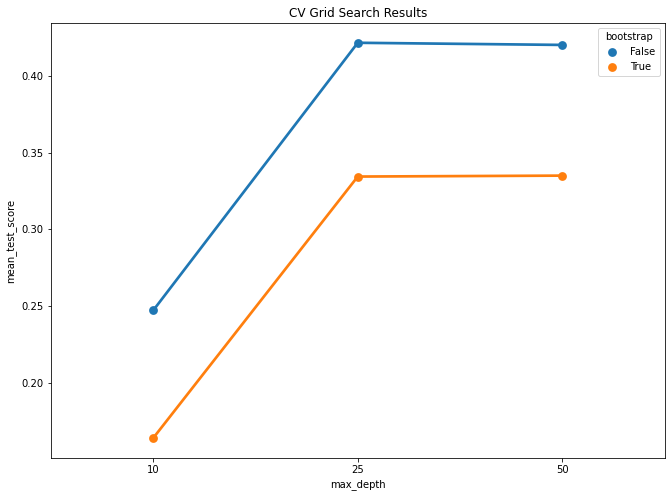

In [35]:
plot_cv_results(rf_classifier_cv.cv_results_, 'max_depth','bootstrap', 'mean_test_score')

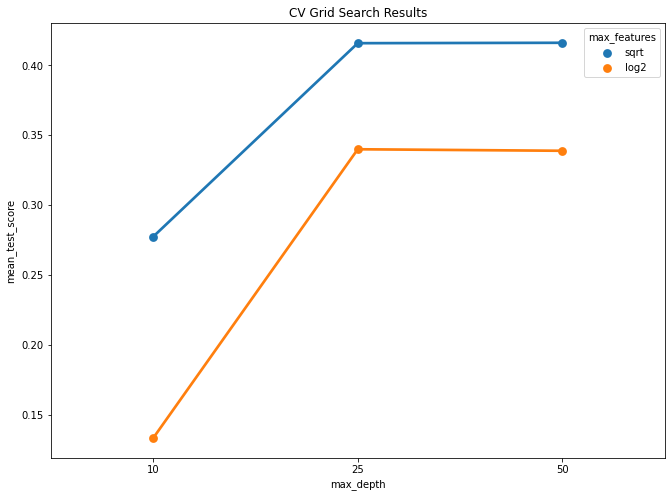

In [36]:
plot_cv_results(rf_classifier_cv.cv_results_, 'max_depth','max_features', 'mean_test_score')

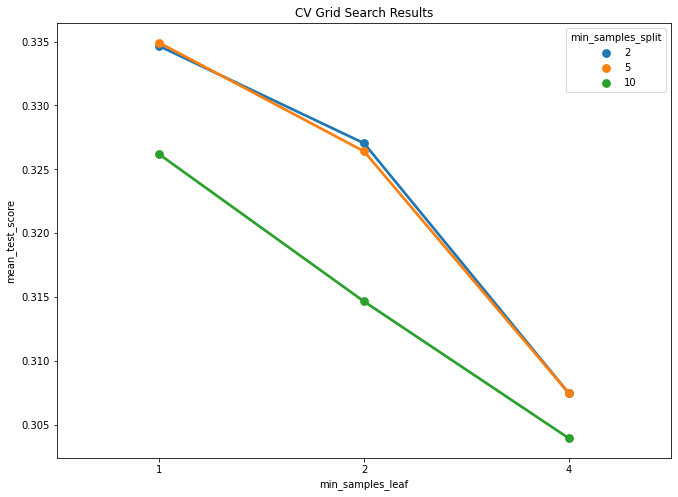

In [37]:
plot_cv_results(rf_classifier_cv.cv_results_, 'min_samples_leaf','min_samples_split', 'mean_test_score')

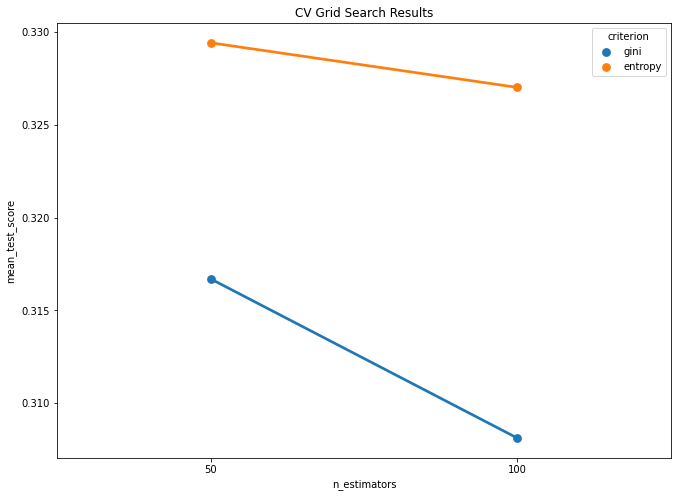

In [38]:
plot_cv_results(rf_classifier_cv.cv_results_, 'n_estimators','criterion', 'mean_test_score')